In [1]:
from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks
from planckmc.detector_characteristics import DETECTOR_CHARACTERISTICS
from planckmc.response import sensor_response, RESPONSE_DICT
from planckmc.config import CONFIG
import planckanalysis.cylinder_integral_transform as pint

import numpy as np
from numba import njit, jit
from tqdm import tqdm
import numericalunits as nu
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from random import randrange, uniform
import json

%matplotlib inline
import matplotlib # plotting libraries

from matplotlib import animation, rc, cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

import seaborn as sn
#%pdb

C:\Users\Bob\anaconda3\lib\site-packages\wimprates\halo.py:144: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


In [2]:
scl_fct = 1e4 # Scale Factor for Optimized Time variables (entry time and time difference)
hnds_un = 1e-2 # Units to Hundreds -> Because Some values are already multiplied by one hundred (i.e. every unit is one hundred of the value)
tnsMS_ms = 1e-1 # Tens of microseconds to microseconds
s_ns = 1e9 # Seconds to nanoseconds
s_ms = 1e6 # Seconds to microseconds

-----------

### SIMULATION ACCELS & DEFINITION OF TRUTH VALUES

The cell below creates a track with its truth values and generates the resultant sensor accelerations (without noise) in the detector

In [56]:
#Custom Track: 7.5 m in length
#vel, entry_vecs, exit_vecs, t_entry, t_exit = np.array([257500.]), np.array([[2.10893786], [3.19662096], [3.51766905]]), np.array([[-3.94093443], [ 3.26567685], [-0.91890723]]), np.array([0.]), np.array([2.91362915e-05])

#t_entry, t_exit are in seconds, the space variables are in meters

#Randomized Track:
#vel = halo_model.generate_vel_array(n_vels=1) # The number infront of n_vels is how many tracks are produced, Keep at one for analysis
#entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape))

#end of randomized track

####Specifically determined track:

# these arbitary values keep the velocity constant and the deviation from vertical constant proportional to the radius of the bounding sphere (which is arb_r)
arb_r = float(CONFIG['Track Generation']['BoundingSphereRadius'])
arb_dev = 0.0 * arb_r # percentage deviation from vertical

entry_vecs = np.array([[0, 0, -arb_r]]).T
exit_vecs = np.array([[arb_dev, arb_dev, arb_r]]).T
t_entry = np.array([0.0])
t_exit = np.array([3.7386881e-06]) * arb_r

vel = np.linalg.norm(exit_vecs-entry_vecs)/t_exit

####end of specifically determined track

track=0 # Identifies that we are looking at the first track, number of tracks is equal to n_vels
radius = float(CONFIG['Track Generation']['BoundingSphereRadius'])
track_len = np.linalg.norm(exit_vecs - entry_vecs)
adc_timestep_size = int(CONFIG['Track Generation']['Timestep'])/s_ns

sensors = tuple(DETECTOR_CHARACTERISTICS.keys()) # Loads the sensor information

# Make sure the linear response in RESPONSE_DICT (simulation) is the same as the one used in the analysis (Run Response_update)
# Eventually, the linear response and the FIR filter used for the template generation, which is currenly this same one, will be the same
# as that of the sensors used in the physical experiment. By matching the two linear responses and FIR filters together, the matching can work

if RESPONSE_DICT['Mode'] == 'individual':
    lin_resp = RESPONSE_DICT[sensors_i[0]]['linear_response']
    lin_resp_len = len(lin_resp)
else:
    lin_resp = RESPONSE_DICT['response_features']['linear_response']
    lin_resp_len = len(lin_resp)

# The floor value is important because of two reasons: 1) it provides a way to analyze for entry time, 2) it makes the length of the data longer than
# the response length (which is CRUCIAL)
floor_val = ((lin_resp_len - (((t_exit - t_entry) * hnds_un * s_ns) + 2)) // 2) + 1

# Padding is in 10s of microseconds (nanoseconds/100)
if floor_val > 1:
    n_pad_strt = randrange(floor_val, floor_val + 5000)
    n_pad_end = randrange(floor_val, floor_val + 5000)
else:
    floor_val = 1
    n_pad_strt = randrange(floor_val, floor_val + 5000)
    n_pad_end = randrange(floor_val, floor_val + 5000)

# Acceleration without noise:
out = make_tracks.generate_acceleration_dict(entry_vecs, exit_vecs, t_entry, t_exit, {'M':1e8, 'G':6.67e-11}, strt_padding=n_pad_strt, end_padding=n_pad_end)

accels = []
sensors_pos = []
cnt = 0

# Below we initialize for the acceleration array and the sensor positions array
for key in out[track]:
    if key not in ['time', 'particle_location']:
        accels.append(out[track][sensors[cnt]])
        sensors_pos.append(DETECTOR_CHARACTERISTICS[key]['position'])
        cnt += 1

## To make a 'zero track', uncomment the line below:
#accels = np.zeros(np.array(accels).shape)

# Below we generate the corresponding truth angle spatial information of the track from the cartesian truth data:
alpha_theta = np.array([0, 0, 1]) # Z-axis
cos_theta_entry = pint.py_ang(entry_vecs.T[0], alpha_theta.T)
if cos_theta_entry < -1:
    cos_theta_entry = -1

if cos_theta_entry > 1:
    cos_theta_entry = 1
theta_entry_truth = np.arccos(cos_theta_entry) # Theta entry truth

cos_theta_exit = pint.py_ang(exit_vecs.T[0], alpha_theta.T)
if cos_theta_exit < -1:
    cos_theta_exit = -1

if cos_theta_exit > 1:
    cos_theta_exit = 1
theta_exit_truth = np.arccos(cos_theta_exit) # Theta exit truth

alpha_phi = np.array([1, 0, 0]) # X-axis
phi_entry_truth = np.arctan2(entry_vecs[1], entry_vecs[0])[0] # Phi entry truth
phi_exit_truth = np.arctan2(exit_vecs[1], exit_vecs[0])[0] # Phi exit truth

# Note: Theta goes from 0 to 180 deg, and phi goes from -180 to 180 deg

t_0 = t_entry + ((n_pad_strt - 1) / (hnds_un * s_ns)) # Truth start time of track; This variable is in Seconds
d_t = t_exit - t_entry # Period of track; This variable is in Seconds

# The conversion below of t_entry and n_pad_strt is what matches the padding and the time to be in nanoseconds -> (t_entry*s_ns)+(n_pad_strt/hnds_un)
sensor_response(sensors[0], out[0][sensors[0]]), track_len, n_pad_strt, n_pad_end, len(out[track]['time']), (t_entry*s_ns)+(n_pad_strt/hnds_un), vel

(array([[33293, 32394, 33919],
        [32123, 32433, 32422],
        [32721, 32900, 32723],
        ...,
        [32117, 34080, 31520],
        [31809, 32262, 32137],
        [33877, 32811, 32203]], dtype=int64),
 7.794,
 1741,
 437,
 2325,
 array([174100.]),
 array([534947.00453884]))

In [57]:
len(sensors)

1000

### NOISY SIMULATION ACCELERATIONS

This cell generates the associated adc values (with added noise) of the accelerations and returns from this digitized data the equivalent accelerations with noise

In [58]:
accels_noise = []
x = sensor_response(sensors[0], accels[0])
full_data_1 = np.array([[0] * 3 for i in range(x.shape[0])])
full_data = np.array([full_data_1 for j in range(len(sensors))])
tm_vals = []

for sensrs in tqdm(range(0,len(sensors))):
    x = sensor_response(sensors[sensrs], accels[sensrs], response_dict=RESPONSE_DICT)
    for tms in range(0,x.shape[0]):
        for dim in range(0,len(x[tms])):
            # adc with noise
            full_data[sensrs][tms][dim] = x[tms][dim]

            
if RESPONSE_DICT['Mode'] == 'individual':
    # currently all sensors are still using the first sensor's reponse, but here is where a loop dealing with that would go
    m = np.array(RESPONSE_DICT[sensors[0]]['signal_transfer_response'])
else:
    m = np.array(RESPONSE_DICT['response_features']['signal_transfer_response'])

# Acceleration with noise
accels_w_noise = pint.adc_readout_to_accel(full_data, np.concatenate([[-1], m[:-1]+np.diff(m)/2, [1]]))
#accels_w_noise = pint.adc_readout_to_accel(full_data, pint.generate_adc_lookup_table(m))

for sensrs2 in range(0,len(sensors)):
    accels_noise.append(accels_w_noise[sensrs2])

100%|██████████| 1000/1000 [00:09<00:00, 106.38it/s]


---------------------

### ANALYSIS ALPHAS GENERATION

This cell takes in the type of analysis requested (for example, a spatial analysis or a velocity and time analysis) and defines the analysis alphas (four vector couples) that are used to generate the templates. The cell also displays how many start times will run in the analysis proper

In [59]:
time_track = out[track]['time']-out[track]['time'][0]

# Input the particular names of the analyses requested into the analysis_parameter below:
    # Analysis Types: 'Time', 'Velocity', 'Spatial', 'Spatial_entry', 'Spatial_exit'

analysis_parameter = ['Time', 'Velocity']


## Note: vel, entry_vecs, exit_vecs, n_pad_strt, n_pad_end, radius, and time_track are all truth values from the simulation

### 'Time' Only Variables: vel, entry_vecs, exit_vecs, time_track

### 'Velocity' Only Variables: num_bins, entry_vecs, exit_vecs, n_pad_strt, n_pad_end, time_track

### 'Time' & 'Velocity' Variables: num_bins, entry_vecs, exit_vecs, time_track

### 'Spatial' Only Variables: vel, n_pad_strt, n_pad_end, radius, N_thetas, N_phis_at_eq, epsilon
### 'Spatial_entry' Only Variables: vel, n_pad_strt, n_pad_end, radius, N_thetas, N_phis_at_eq, epsilon, entry_Anl=True, exit_vals=[theta_exit_truth, phi_exit_truth]
### 'Spatial_exit' Only Variables: vel, n_pad_strt, n_pad_end, radius, N_thetas, N_phis_at_eq, epsilon, exit_Anl=True, entry_vals=[theta_entry_truth, phi_entry_truth]

### 'Spatial' & 'Velocity' Variables: num_bins, n_pad_strt, n_pad_end, radius, N_thetas, N_phis_at_eq, epsilon
### 'Spatial_entry' & 'Velocity' Variables: num_bins, n_pad_strt, n_pad_end, radius, N_thetas, N_phis_at_eq, epsilon, entry_Anl=True, exit_vals=[theta_exit_truth, phi_exit_truth]
### 'Spatial_exit' & 'Velocity' Variables:  num_bins, n_pad_strt, n_pad_end, radius, N_thetas, N_phis_at_eq, epsilon, exit_Anl=True, entry_vals=[theta_entry_truth, phi_entry_truth]

### 'Spatial' & 'Time' Variables: vel, radius, N_thetas, N_phis_at_eq, epsilon
### 'Spatial_entry' & 'Time' Variables: vel, radius, N_thetas, N_phis_at_eq, epsilon, exit_vals=[theta_exit_truth, phi_exit_truth]
### 'Spatial_exit' & 'Time' Variables:  vel, radius, N_thetas, N_phis_at_eq, epsilon, entry_vals=[theta_entry_truth, phi_entry_truth]

### 'Spatial' & 'Velocity' & 'Time' Variables: num_bins, radius, N_thetas, N_phis_at_eq, epsilon
### 'Spatial_entry' & 'Velocity' & 'Time' Variables: num_bins, radius, N_thetas, N_phis_at_eq, epsilon, exit_vals=[theta_exit_truth, phi_exit_truth]
### 'Spatial_exit' & 'Velocity' & 'Time' Variables:  num_bins, radius, N_thetas, N_phis_at_eq, epsilon, entry_vals=[theta_entry_truth, phi_entry_truth]

num_thetas = 15
num_phis_at_eq  = 2*num_thetas

if 'Velocity' in analysis_parameter:
    num_bin = 100
    velocity_bins = np.linspace(1e5, 8e5, num_bin)
    vel_array = velocity_bins[:-1] + np.diff(velocity_bins) / 2
else:
    vel_array = [vel]

if 'Time' in analysis_parameter:
    # Acceleration Settings: Analyzing the whole time parameter space
    tm_steps = 2
    tmstep_strt = 0
    tmstep_end = len(time_track) - 1
else:
    # Acceleration Settings: Removing the padding and only considering the true entry time
    tm_steps = len(time_track) - n_pad_strt - n_pad_end
    tmstep_strt = n_pad_strt - 1
    tmstep_end = len(time_track) - n_pad_end - 1

length_of_run = int((tmstep_end-tmstep_strt) / tm_steps)
print("Number of start times:", length_of_run)

if 'Spatial' in analysis_parameter:
    alphas, angles = pint.Spatial_Analysis_alphas(vel=vel_array, radius=radius, N_thetas=num_thetas, N_phis_at_eq=num_phis_at_eq)
elif 'Spatial_entry' in analysis_parameter:
    alphas, angles = pint.Spatial_Analysis_alphas(vel=vel_array, radius=radius, entry_Anl=True,
                                           exit_vals=[theta_exit_truth, phi_exit_truth], N_thetas=num_thetas, N_phis_at_eq=num_phis_at_eq)
elif 'Spatial_exit' in analysis_parameter:
    alphas, angles = pint.Spatial_Analysis_alphas(vel=vel_array, radius=radius, exit_Anl=True,
                                           entry_vals=[theta_entry_truth, phi_entry_truth], N_thetas=num_thetas, N_phis_at_eq=num_phis_at_eq)
else:
    alphas = pint.Non_Spatial_Analysis_alphas(vel_array, entry_vecs, exit_vecs)

100%|██████████| 99/99 [00:00<00:00, 99101.69it/s]

Number of start times: 1162


---------------------

### TEMPLATE GENERATION

This block runs transform_temp given the alphas, sensor positions, linear response, and timestep size. template_operation gives back the Library Templates composed of each sensor's accelerations in the 3 dimensions for each timestep in the generated track.

In [60]:
def template_operation(alphas, sensors_pos, lin_resp, adc_timestep_size, cylinder_cut_size):
    expected_signal_from_sensor = pint.transform_temp(np.array(alphas), sensors_pos, lin_resp, adc_timestep_size, cylinder_cut_size)
    
    #BIG NOTE: the linear response passed in now is the linear response that goes to the simulation (in the noise cell), which is good. However, once
    #whitening is employed and what goes into the noise cell (simulation) is the correct FIR filter, the filter that goes in here should remain the delta
    #filter - REMEMBER to make that distinction
    
    return expected_signal_from_sensor

In [61]:
cylinder_cut_size = 1
Library = template_operation(alphas, sensors_pos, lin_resp, adc_timestep_size, cylinder_cut_size)

100%|██████████| 99/99 [00:10<00:00,  9.06it/s]


In [62]:
np.array(Library['Signal'][0]).shape

(120, 753, 3)

---------------------

### PERFORMING THE ANALYSIS

This cell block runs the integral transform given the times, start time analysis information, accelerations, alphas, sensor positions, and the Template Library. An analysis of the noise data is done when the noisy accelerations are the ones passed through. Transform gives back an SNR value and two associated four-vectors (x,y,z,t) for each of the templates considered in the analysis

NOTE: The output of the conjoined integral transform function is the S value, not the SNR.
    And this value cannot be transformed into the SNR trivially. This is because of how the
    function is set up and how the expected signal from the sensor is generated. In this function, for
    every sensor, an expected signal is generated, analyzed with the data, then discarded.
    The result of each run is added continously and the final value is the S, but each
    expected signal has been lost and cannot be used for the SNR calculation (see the
    separated integral transform for comparison). So, it is not recomended to use the conjoined transform, and if it becomes necessary to use 
    (such as in optimization), keep this piece of information in mind.

In [63]:
def transform_function(time_track, tm_steps, tmstep_strt, tmstep_end, accels, alphas, Library):
    start_time_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
    start_times = time_track[start_time_indices]

    transformed_data = pint.transform_calc(accels, np.array(alphas), time_track/1e9, start_times/1e9, start_time_indices, Library)    
    return transformed_data

In [64]:
if tm_steps == len(time_track) and (tmstep_strt != n_pad_strt - 1 or tmstep_end != len(time_track) - n_pad_end):
    raise ValueError("You are only analyzing 1 time step, but you also are considering the padding. Please input correct values")
else:
    transformed_data = transform_function(time_track, tm_steps, tmstep_strt, tmstep_end, accels, alphas, Library)

100%|██████████| 1162/1162 [03:00<00:00,  6.45it/s]


In [65]:
def transform_function_noise(time_track, tm_steps, tmstep_strt, tmstep_end, accels_noise, alphas, Library):
    start_time_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
    start_times = time_track[start_time_indices]
    
    transformed_data = pint.transform_calc(accels_noise, np.array(alphas), time_track/1e9, start_times/1e9, start_time_indices, Library)
    return transformed_data

In [66]:
# Necessary: Analysis W/ Noise
# Runs integral transform given the times, accelerations with noise, alphas, and sensor positions
# Transform has the same format as the cell above

if tm_steps == len(time_track) and (tmstep_strt != n_pad_strt - 1 or tmstep_end != len(time_track) - n_pad_end):
    raise ValueError("You are only analyzing 1 time step, but you also are considering the padding. Please input correct values")
else:
    transformed_data_noise = transform_function_noise(time_track, tm_steps, tmstep_strt, tmstep_end, accels_noise, alphas, Library)

100%|██████████| 1162/1162 [02:56<00:00,  6.58it/s]


---------------------

### PRESENTING THE RESULTS

In [67]:
transformed_data

array([(-0.00059313, 0., 0., -3.897, 0.       , 0., 0., 3.897, 7.52786341e-05, 753),
       (-0.00050474, 0., 0., -3.897, 0.       , 0., 0., 3.897, 7.04663014e-05, 705),
       (-0.00043659, 0., 0., -3.897, 0.       , 0., 0., 3.897, 6.62322747e-05, 663),
       ...,
       (-0.00462567, 0., 0., -3.897, 0.0002322, 0., 0., 3.897, 2.42162634e-04,   2),
       (-0.00462521, 0., 0., -3.897, 0.0002322, 0., 0., 3.897, 2.42073397e-04,   2),
       (-0.00462476, 0., 0., -3.897, 0.0002322, 0., 0., 3.897, 2.41985745e-04,   2)],
      dtype=[('SNR', '<f8'), ('alpha0_x', '<f8'), ('alpha0_y', '<f8'), ('alpha0_z', '<f8'), ('alpha0_t', '<f8'), ('alpha1_x', '<f8'), ('alpha1_y', '<f8'), ('alpha1_z', '<f8'), ('alpha1_t', '<f8'), ('steps', '<i4')])

In [68]:
Result_vals = transformed_data[np.argmax(transformed_data['SNR'])]
Result_vals

(58.88752078, 0., 0., -3.897, 0.000174, 0., 0., 3.897, 0.00018877, 148)

In [69]:
theta_entry_calc = np.arccos(Result_vals[3] / np.sqrt(Result_vals[1] ** 2 + Result_vals[2] ** 2 + Result_vals[3] ** 2))
theta_exit_calc = np.arccos(Result_vals[7] / np.sqrt(Result_vals[5] ** 2 + Result_vals[6] ** 2 + Result_vals[7] ** 2))
phi_entry_calc = np.arctan2(Result_vals[2], Result_vals[1])
phi_exit_calc = np.arctan2(Result_vals[6], Result_vals[5])
Result_vals[4], Result_vals[8], theta_entry_calc, phi_entry_calc, theta_exit_calc, phi_exit_calc

(0.000174, 0.00018876757894736843, 3.141592653589793, 0.0, 0.0, 0.0)

In [70]:
t_0, t_0+d_t, theta_entry_truth, phi_entry_truth, theta_exit_truth, phi_exit_truth

(array([0.000174]), array([0.00018857]), 3.141592653589793, 0.0, 0.0, 0.0)

In [71]:
# Format: variable = np.array(transformed_data['variable_name'])

SNR_data_plt = np.array(transformed_data['SNR'])

# Calculate variable from the standard varaibles of transform if necessary (e.g. theta from the cartesian coordinates)

tm_strt_plt = np.array(transformed_data['alpha0_t'])
tm_end_plt = np.array(transformed_data['alpha1_t'])
vel_plt = np.array(np.sqrt((transformed_data['alpha1_x'] - transformed_data['alpha0_x'])**2 +
                   (transformed_data['alpha1_y'] - transformed_data['alpha0_y'])**2 +
                   (transformed_data['alpha1_z'] - transformed_data['alpha0_z'])**2) / (transformed_data['alpha1_t'] - transformed_data['alpha0_t']))

theta_entry_plt = np.arccos(transformed_data['alpha0_z'] / np.sqrt(transformed_data['alpha0_x'] ** 2 + transformed_data['alpha0_y'] ** 2 + transformed_data['alpha0_z'] ** 2))
theta_exit_plt = np.arccos(transformed_data['alpha1_z'] / np.sqrt(transformed_data['alpha1_x'] ** 2 + transformed_data['alpha1_y'] ** 2 + transformed_data['alpha1_z'] ** 2))
phi_entry_plt = np.arctan2(transformed_data['alpha0_y'], transformed_data['alpha0_x'])
phi_exit_plt = np.arctan2(transformed_data['alpha1_y'], transformed_data['alpha1_x'])

In [72]:
# Format: variable_noise = np.array(transformed_data_noise['variable_name'])

SNR_data_plt_noise = np.array(transformed_data_noise['SNR'])

# Calculate variable from the standard varaibles of transform if necessary (e.g. theta from the cartesian coordinates)

tm_strt_plt_noise = np.array(transformed_data_noise['alpha0_t'])
tm_end_plt_noise = np.array(transformed_data_noise['alpha1_t'])
vel_plt_noise = np.array(np.sqrt((transformed_data_noise['alpha1_x'] - transformed_data_noise['alpha0_x'])**2 +
                                 (transformed_data_noise['alpha1_y'] - transformed_data_noise['alpha0_y'])**2 +
                                 (transformed_data_noise['alpha1_z'] - transformed_data_noise['alpha0_z'])**2) / (transformed_data_noise['alpha1_t'] - transformed_data_noise['alpha0_t']))

theta_entry_plt_noise = np.arccos(transformed_data_noise['alpha0_z'] / np.sqrt(transformed_data_noise['alpha0_x'] ** 2 + transformed_data_noise['alpha0_y'] ** 2 + transformed_data_noise['alpha0_z'] ** 2))
theta_exit_plt_noise = np.arccos(transformed_data_noise['alpha1_z'] / np.sqrt(transformed_data_noise['alpha1_x'] ** 2 + transformed_data_noise['alpha1_y'] ** 2 + transformed_data_noise['alpha1_z'] ** 2))
phi_entry_plt_noise = np.arctan2(transformed_data_noise['alpha0_y'], transformed_data_noise['alpha0_x'])
phi_exit_plt_noise = np.arctan2(transformed_data_noise['alpha1_y'], transformed_data_noise['alpha1_x'])

In [73]:
# Full width Half Maximum Calculations

hf_max_SNR = np.max(transformed_data['SNR']) / 2

# Prominence (Maximum) Determination: Direct Assignment is possible; peak_prominences allows for calculations of correct left and right bases
prominence_info = peak_prominences(x=transformed_data['SNR'], peaks=[np.argmax(transformed_data['SNR'])])
prominence = [np.array([np.max(transformed_data['SNR'])]), prominence_info[1], prominence_info[2]]

# Fwhm Calculation:
fwhm_data = peak_widths(x=transformed_data['SNR'], peaks=[np.argmax(transformed_data['SNR'])], rel_height=0.5, prominence_data=prominence)

# Output of function: widths of each each peak in samples (# of indices), width heights (height of where widths are determined),
#                     left interpolated position (left-most index of full-width), right interpolated position (Right-most index of full-width)

#### Entry Time vs. SNR:


 # of indices =  18 , fwhm =  0.0
-----------------------------------------------------------


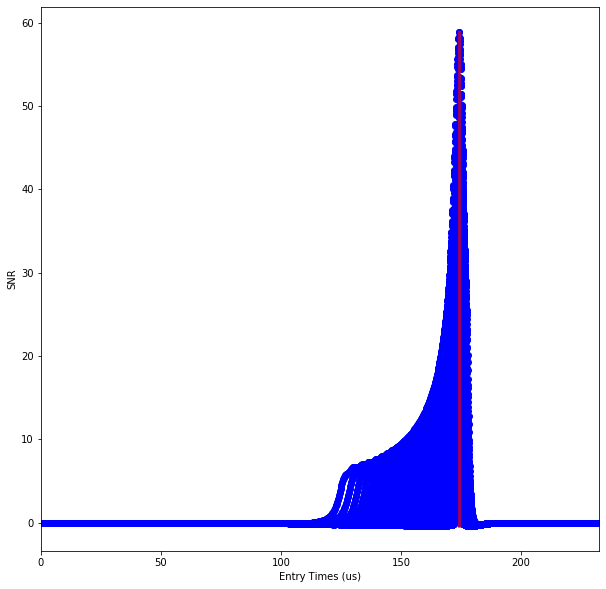

In [74]:
X_Val1 = [(n_pad_strt - 1) / 10, (n_pad_strt - 1) / 10] # Actual Variable Value of Track
Y_Val1 = [min(SNR_data_plt), max(SNR_data_plt)] # If plotting S -> min & max of S_data_plt, If plotting S -> min & max of S_data_plt


fig1 = plt.figure(figsize=[10,10])
plt.plot(tm_strt_plt * 10**6, SNR_data_plt, 'bo', alpha=1) # Input variable as the X axis & S for the y axis
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.plot([tm_strt_plt[int(fwhm_data[2])] * 10**6, tm_strt_plt[int(fwhm_data[3])] * 10**6], [hf_max_SNR, hf_max_SNR], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(tm_strt_plt[int(fwhm_data[2])] - tm_strt_plt[int(fwhm_data[3])]) * 10**6)
print('-----------------------------------------------------------')

plt.xlim(t_entry * 10**6, t_entry * 10**6 + n_pad_strt / 10 + t_exit  * 10**6 + n_pad_end / 10) # Put ranges if necessary, careful of padding
plt.ylabel('SNR')
plt.xlabel('Entry Times (us)')
plt.show()

#### Entry Time vs. SNR w/ Noise:

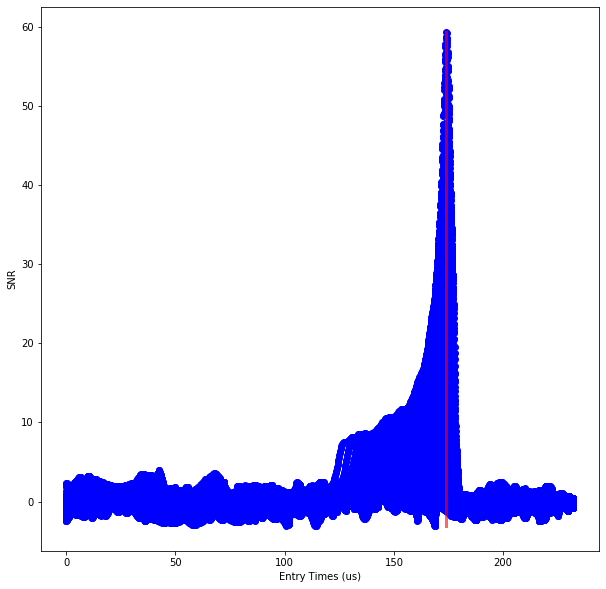

In [75]:
# Same format as above

X_Val1 = [(n_pad_strt - 1) / 10, (n_pad_strt - 1) / 10] # Actual Variable Value of Track
Y_Val1 = [min(SNR_data_plt_noise), max(SNR_data_plt_noise)]

fig2 = plt.figure(figsize=[10,10])
plt.plot(tm_strt_plt_noise * 10**6, SNR_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

#plt.xlim(t_entry * 10**6, t_entry * 10**6 + n_pad_strt / 10 + t_exit  * 10**6 + n_pad_end / 10) # Put ranges if necessary, careful of padding
plt.ylabel('SNR')
plt.xlabel('Entry Times (us)')
plt.show()

In [13]:
fig2.savefig('(3.897m)r x cubic(10x10x10)s, (50cm)sens_sep _ cylinder analysis_ vert_k, time_plt 250 bins.png')

#### Exit Time vs. SNR:


 # of indices =  18 , fwhm =  3.6137135656865405
-----------------------------------------------------------


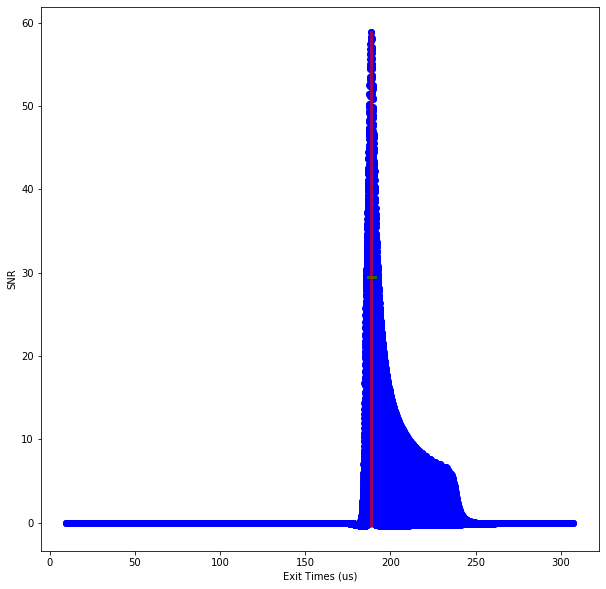

In [76]:
X_Val1 = [(out[track]['time'][-1] + (n_pad_strt - (n_pad_end-1)) * 100) / 1000, (out[track]['time'][-1] + (n_pad_strt - (n_pad_end-1)) * 100) / 1000]
Y_Val1 = [min(SNR_data_plt), max(SNR_data_plt)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(tm_end_plt * 10**6, SNR_data_plt, 'bo', alpha=1)

plt.plot([tm_end_plt[int(fwhm_data[2])] * 10**6, tm_end_plt[int(fwhm_data[3])] * 10**6], [hf_max_SNR, hf_max_SNR], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(tm_end_plt[int(fwhm_data[2])] - tm_end_plt[int(fwhm_data[3])]) * 10**6)
print('-----------------------------------------------------------')

plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)
plt.ylabel('SNR')
plt.xlabel('Exit Times (us)')
plt.show()

#### Exit Time vs. SNR w/ Noise:

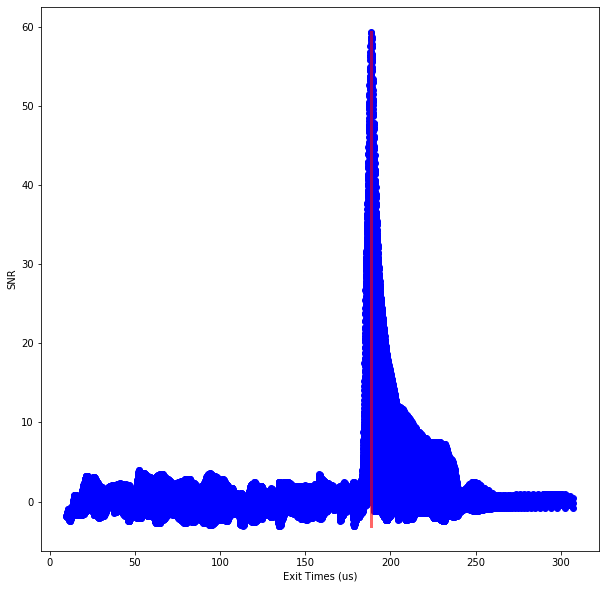

In [77]:
# Exit Time vs. SNR w/ Noise

X_Val1 = [(len(time_track) - n_pad_end)/10, (len(accels_noise[0]) - n_pad_end - lin_resp_len + 1)/10]
Y_Val1 = [min(SNR_data_plt_noise), max(SNR_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(tm_end_plt_noise * 10**6, SNR_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('SNR')
plt.xlabel('Exit Times (us)')
plt.show()

#### Velocity vs. SNR:

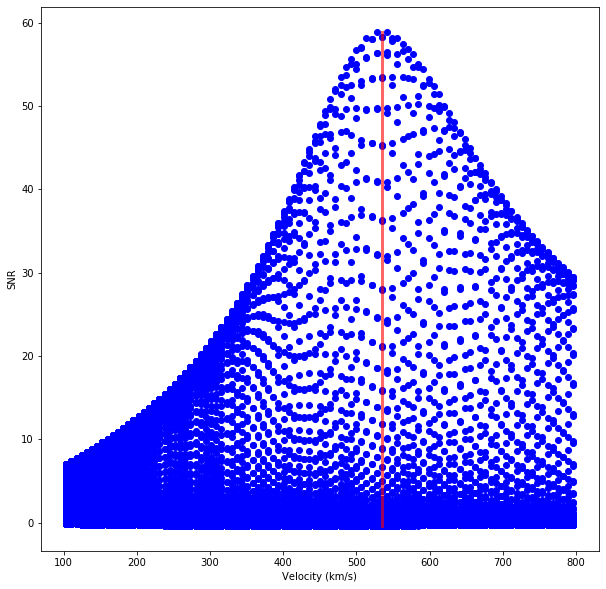

In [78]:
# Velocity vs. SNR

X_Val1 = [vel/1000, vel/1000]
Y_Val1 = [min(SNR_data_plt), max(SNR_data_plt)]

fig4 = plt.figure(figsize=[10,10])
plt.plot(vel_plt/1000, SNR_data_plt, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

if 'Velocity' in analysis_parameter:
    vel_step = vel_plt[1] - vel_plt[0]
else:
    vel_step = 0

#plt.plot([1e2 + fwhm_data[2] * vel_step / 1000, 1e2 + fwhm_data[3] * vel_step / 1000], [hf_max_SNR, hf_max_SNR], 'g', alpha=1, linewidth = 3)
#print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(vel_plt[int(fwhm_data[2])] - vel_plt[int(fwhm_data[3])])/1000)
#print('-----------------------------------------------------------')

plt.ylabel('SNR')
plt.xlabel('Velocity (km/s)')
plt.show()

#### Velocity vs. SNR w/ Noise:

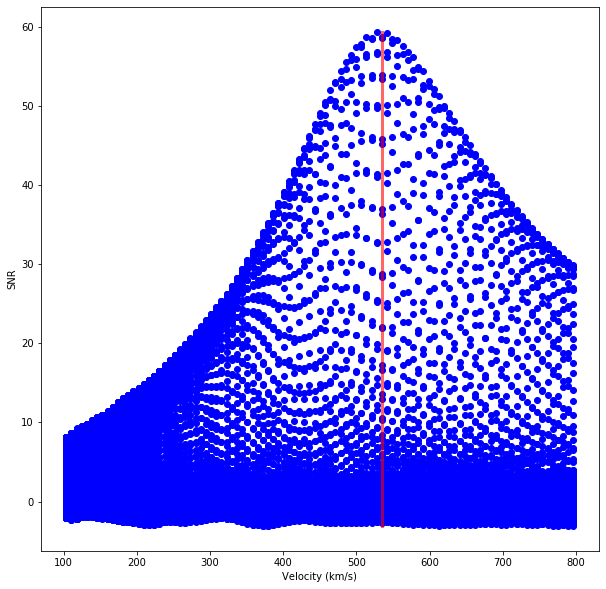

In [79]:
# Velocity vs. SNR w/ Noise

X_Val1 = [vel/1000, vel/1000]
Y_Val1 = [min(SNR_data_plt_noise), max(SNR_data_plt_noise)]

fig4 = plt.figure(figsize=[10,10])
plt.plot(vel_plt_noise/1000, SNR_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('SNR')
plt.xlabel('Velocity (km/s)')
plt.show()

In [15]:
fig4.savefig('(3.897m)r x cubic(10x10x10)s, (50cm)sens_sep _ cylinder analysis_ vert_k, vel_plt 100 bins.png')

#### Theta entry vs. SNR w/ Noise:

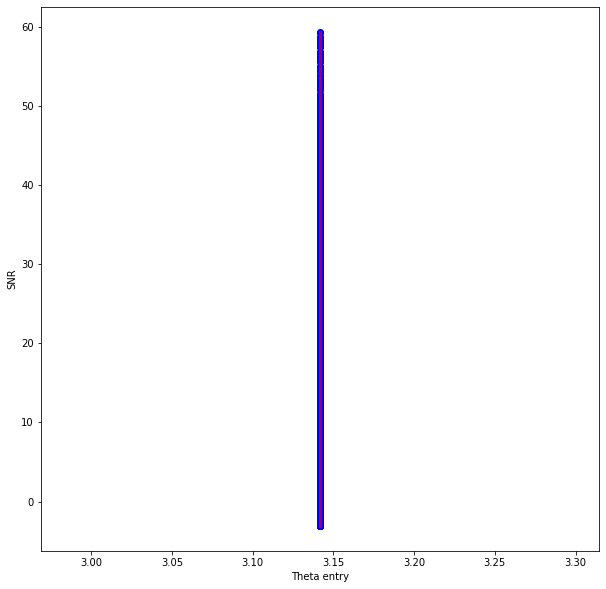

In [80]:
# theta entry vs SNR w/ Noise

X_Val1 = [theta_entry_truth, theta_entry_truth]
Y_Val1 = [min(SNR_data_plt_noise), max(SNR_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_entry_plt_noise, SNR_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

#plt.plot([theta_entry_plt[int(fwhm_data[2])], theta_entry_plt[int(fwhm_data[3])]], [hf_max_SNR, hf_max_SNR], 'g', alpha=1, linewidth = 3)
#print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(theta_entry_plt[int(fwhm_data[2])] - theta_entry_plt[int(fwhm_data[3])]))
#print('-----------------------------------------------------------')

plt.ylabel('SNR')
plt.xlabel('Theta entry')
plt.show()

#### Phi entry vs. SNR w/ Noise:

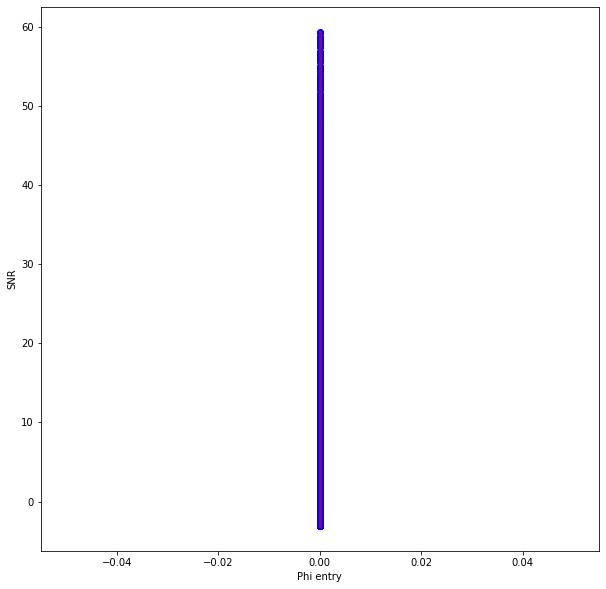

In [81]:
# phi entry vs SNR w/ Noise

X_Val1 = [phi_entry_truth, phi_entry_truth]
Y_Val1 = [min(SNR_data_plt_noise), max(SNR_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(phi_entry_plt_noise, SNR_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

#plt.plot([phi_entry_plt[int(fwhm_data[2])], phi_entry_plt[int(fwhm_data[3])]], [hf_max_SNR, hf_max_SNR], 'g', alpha=1, linewidth = 3)
#print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(phi_entry_plt[int(fwhm_data[2])] - phi_entry_plt[int(fwhm_data[3])]))
#print('-----------------------------------------------------------')

plt.ylabel('SNR')
plt.xlabel('Phi entry')
plt.show()

#### Theta exit vs. SNR w/ Noise:

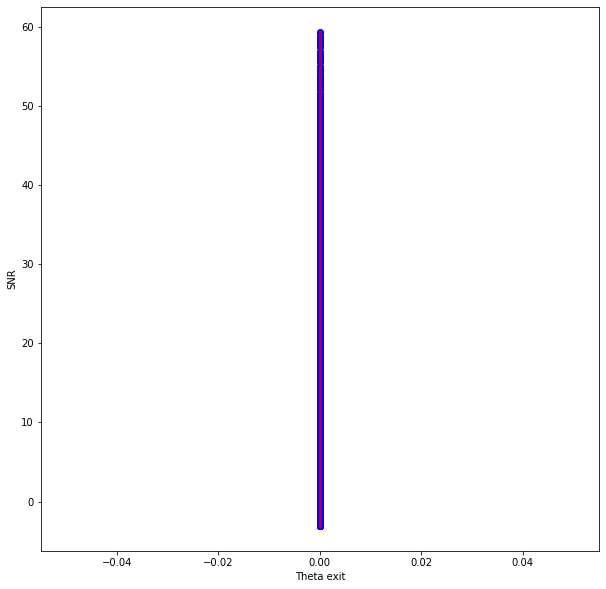

In [82]:
# theta exit vs SNR w/ Noise

X_Val1 = [theta_exit_truth, theta_exit_truth]
Y_Val1 = [min(SNR_data_plt_noise), max(SNR_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_exit_plt_noise, SNR_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

#plt.plot([theta_exit_plt[int(fwhm_data[2])], theta_exit_plt[int(fwhm_data[3])]], [hf_max_SNR, hf_max_SNR], 'g', alpha=1, linewidth = 3)
#print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(theta_exit_plt[int(fwhm_data[2])] - theta_exit_plt[int(fwhm_data[3])]))
#print('-----------------------------------------------------------')

plt.ylabel('SNR')
plt.xlabel('Theta exit')
plt.show()

#### Phi exit vs. SNR w/ Noise:

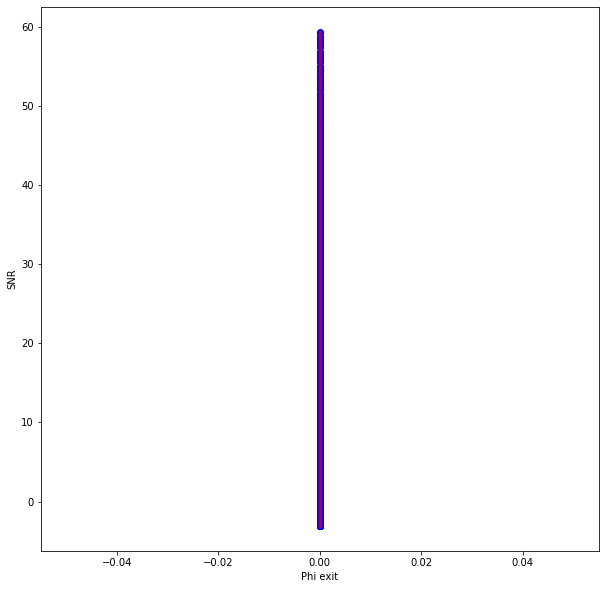

In [83]:
# phi exit vs SNR w/ Noise

X_Val1 = [phi_exit_truth, phi_exit_truth]
Y_Val1 = [min(SNR_data_plt_noise), max(SNR_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(phi_exit_plt_noise, SNR_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

#plt.plot([phi_exit_plt[int(fwhm_data[2])], phi_exit_plt[int(fwhm_data[3])]], [hf_max_SNR, hf_max_SNR], 'g', alpha=1, linewidth = 3)
#print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(phi_exit_plt[int(fwhm_data[2])] - phi_exit_plt[int(fwhm_data[3])]))
#print('-----------------------------------------------------------')

plt.ylabel('SNR')
plt.xlabel('Phi exit')
plt.show()

---------------------

#### SNR Histogram:

In [14]:
f_val = 0
for i, x in enumerate(tqdm(transformed_data_noise['SNR'])):
    f_val += (x - np.average(transformed_data_noise['SNR']))**2

sigma = np.sqrt(f_val/len(transformed_data_noise['SNR']))
plt.yscale('log')

print("Sigma =", sigma)

100%|██████████| 132468/132468 [00:52<00:00, 2510.06it/s]

Sigma = 0.9910808382758007


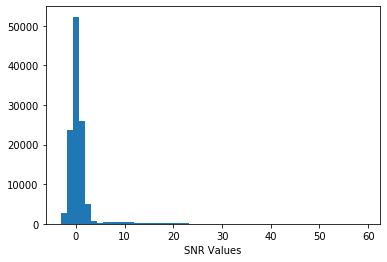

In [85]:
plt.hist(transformed_data_noise['SNR'], bins=50)
#plt.xlim(np.min(transformed_data_noise['SNR']),np.max(transformed_data_noise['SNR']))
plt.xlabel('SNR Values')
plt.show()

In [84]:
np.max(transformed_data_noise['SNR'])

59.381421751161746

---------------------

#### 2P (velocity and time) 2D Histogram:

In [89]:
timestep_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
timesteps = time_track[timestep_indices]

if 'Velocity' in analysis_parameter:
    v_bin_edges = np.linspace(1e5, 7e5, 30)
else:
    v_bin_edges = vel

if len(timesteps) > 1:
    timestep_edges = list(timesteps-(timesteps[1]-timesteps[0])/2)
    timestep_edges.append(timesteps[-1] + (timesteps[1]-timesteps[0])/2)
    timestep_edges = np.array(timestep_edges)*1e-3
else:
    timestep_edges = np.array([timesteps[0] * 1e-3])

X, Y = np.meshgrid(timestep_edges, v_bin_edges)
C = np.zeros(X.shape)

In [90]:
analysis_min_steps = 10
#for i_row,row in enumerate(transformed_data):
for i_row,row in enumerate(transformed_data_noise):
    j = np.searchsorted(timestep_edges, row['alpha0_t']*1e6) - 1
    i = np.searchsorted(v_bin_edges, vel_plt_noise[i_row]) - 1
    C[i,j] = row['SNR']

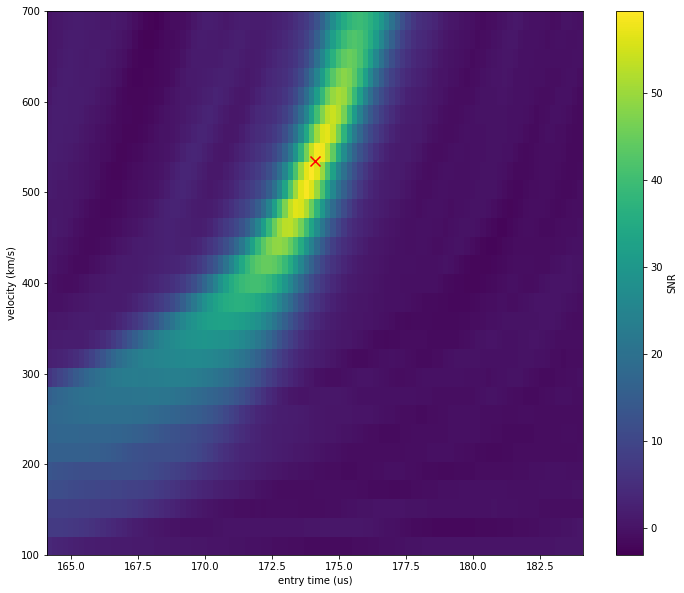

In [91]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(X,Y/1e3,C)
ax.scatter(n_pad_strt*0.1, vel[0]/1e3, c='red', marker='x', s=100)
ax.set(xlabel='entry time (us)', ylabel='velocity (km/s)', xlim=(n_pad_strt*0.1 - 10, n_pad_strt*0.1 + 10))
# ax.scatter((len(time) - n_pad_end)/10, vel[0]/1e3, c='red', marker='x', s=100)
# ax.set(xlabel='exit time (us)', ylabel='velocity (km/s)')
plt.colorbar(pcm, label='SNR')
plt.show()

In [21]:
fig.savefig('(3.897m)r x cubic(10x10x10)s, (50cm)sens_sep _ cylinder analysis_ vert_k, 100 bins.png')

---------------------

In [21]:
dist_actl = np.ones((len(accels), len(sensors_pos)))
accl_actl = np.ones((len(accels), len(sensors)))
lim_actl_loc = np.ones((len(accels), len(sensors)))
lim_actl = np.ones((len(accels), len(sensors)))
out_len = len(out)
sen_len = len(sensors)

for lim1_loc in range(0, out_len):
    for lim2_loc in range(0, sen_len):
        for lim3_loc in range(0, len(out[lim1_loc]['particle_location'])):
            dist_sens_part = np.linalg.norm(sensors_pos[lim2_loc] - out[lim1_loc]['particle_location'][lim3_loc])
            if lim3_loc == 0:
                dist_actl[lim1_loc][lim2_loc] = dist_sens_part
                lim_actl_loc[lim1_loc][lim2_loc] = lim3_loc
            elif dist_sens_part < dist_actl[lim1_loc][lim2_loc]:
                dist_actl[lim1_loc][lim2_loc] = dist_sens_part
                lim_actl_loc[lim1_loc][lim2_loc] = lim3_loc
                lim_actl[lim1_loc==6]

for lim1_acc in range(0, out_len):
    for lim2_acc in tqdm(range(0, sen_len)):
        for lim3_acc in range(0, len(out[lim1_acc][sensors[lim2_acc]])):
            accl = np.linalg.norm(out[lim1_acc][sensors[lim2_acc]][lim3_acc])
            if lim3_acc == 0:
                accl_actl[lim1_acc][lim2_acc] = accl
                lim_actl[lim1_acc][lim2_acc] = lim3_acc
            elif accl > accl_actl[lim1_acc][lim2_acc]:
                accl_actl[lim1_acc][lim2_acc] = accl
                lim_actl[lim1_acc][lim2_acc] = lim3_acc

100%|██████████| 48/48 [00:00<00:00, 52.04it/s]


100%|██████████| 48/48 [00:25<00:00,  1.85it/s]


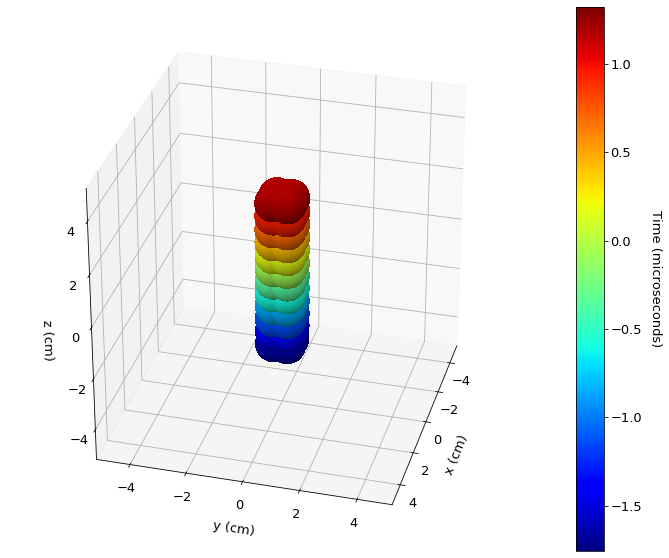

In [22]:
partl_num = 1
fig1 = plt.figure(figsize=(12,10))
ax1 = fig1.add_subplot(111, projection='3d')

ax1.clear()
positions2 = np.array(sensors_pos)
ax1.elev = 30
ax1.azim = 15
ax1.set(xlim=[-5,5],ylim=[-5,5],zlim=[-5,5])
ax1.set_xlabel('x (cm)', fontsize=13, labelpad=10)
ax1.set_ylabel('y (cm)', fontsize=13, labelpad=10)
ax1.set_zlabel('z (cm)', fontsize=13, labelpad=10)
ax1.tick_params(labelsize=13)

cbar = fig1.colorbar(cm.ScalarMappable(norm=clr.Normalize(min(out[partl_num-1]['time'])/100000,max(out[partl_num-1]['time'])/100000), cmap='jet'), ax=ax1)
cbar.ax.set_ylabel('Time (microseconds)', rotation=270, fontsize=13)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.tick_params(labelsize=13)

mags = []
sz_sen = []
for sens in range(0, sen_len):
    for len_outAccls in range(0, len(out[partl_num-1][sensors[sens]])):
        mags.append(np.linalg.norm(out[partl_num-1][sensors[sens]][len_outAccls]))
mags_mx = max(mags)
mags_mn = min(mags)
lim_cl_all = lim_actl[partl_num-1]

for sens in tqdm(range(0, sen_len)):
    lim_cl = int(lim_cl_all[sens])
    sz_sen.append((accl_actl[partl_num-1][sens]-mags_mn) / (mags_mx-mags_mn))
        
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = (sz_sen[sens] * 0.25)**(1/3) * np.outer(np.cos(u), np.sin(v)) + positions2.T[0][sens]
    y = (sz_sen[sens] * 0.25)**(1/3) * np.outer(np.sin(u), np.sin(v)) + positions2.T[1][sens]
    z = (sz_sen[sens] * 0.25)**(1/3) * np.outer(np.ones(np.size(u)), np.cos(v)) + positions2.T[2][sens]
    
#     x = (sz_sen[sens] * 2)**(1/3) * np.outer(np.cos(u), np.sin(v)) + positions2.T[0][sens]
#     y = (sz_sen[sens] * 2)**(1/3) * np.outer(np.sin(u), np.sin(v)) + positions2.T[1][sens]
#     z = (sz_sen[sens] * 2)**(1/3) * np.outer(np.ones(np.size(u)), np.cos(v)) + positions2.T[2][sens]
    
    norm = clr.Normalize(vmin=out[partl_num-1]['time'][int(min(lim_cl_all))] - 500, vmax=out[partl_num-1]['time'][int(max(lim_cl_all))] + 500)
    val = norm(int(out[partl_num-1]['time'][lim_cl]))
    mp = plt.get_cmap('jet')
    colr = mp(val)
    
    ax1.plot_surface(x, y, z, color=colr, alpha=1, rcount = 100, ccount = 100, shade=True, antialiased=False, lightsource=LightSource(altdeg=110))
    
#x2 = (0.5 * np.outer(np.cos(u), np.sin(v))) + out[partl_num-1]['particle_location'][len(out[0]['particle_location'])-1,0]
#y2 = (0.5 * np.outer(np.sin(u), np.sin(v))) + out[partl_num-1]['particle_location'][len(out[0]['particle_location'])-1,1]
#z2 = (0.5 * np.outer(np.ones(np.size(u)), np.cos(v))) + out[partl_num-1]['particle_location'][len(out[0]['particle_location'])-1,2]
#particle = ax1.plot_surface(x2, y2, z2, color='black', alpha=1, rcount = 100, ccount = 100, shade=True, antialiased=False, lightsource=LightSource(altdeg=110))

start_x = out[partl_num-1]['particle_location'][int(min(lim_cl_all))-1,0]
start_y = out[partl_num-1]['particle_location'][int(min(lim_cl_all))-1,1]
start_z = out[partl_num-1]['particle_location'][int(min(lim_cl_all))-1,2]
#end_x = out[partl_num-1]['particle_location'][int(max(lim_cl_all))-1,0] - out[partl_num-1]['particle_location'][int(min(lim_cl_all))-1,0]
#end_y = out[partl_num-1]['particle_location'][int(max(lim_cl_all))-1,1] - out[partl_num-1]['particle_location'][int(min(lim_cl_all))-1,1]
#end_z = out[partl_num-1]['particle_location'][int(max(lim_cl_all))-1,2] - out[partl_num-1]['particle_location'][int(min(lim_cl_all))-1,2]

#start_x = out[partl_num-1]['particle_location'][0,0]
#start_y = out[partl_num-1]['particle_location'][0,1]
#start_z = out[partl_num-1]['particle_location'][0,2]

#ax1.quiver(start_x, start_y, start_z, 10.24882124-start_x,  -1.46311785-start_y, -12.06487928-start_z, color='black', normalize=False, arrow_length_ratio=0.1)

#plt.axis('off')

In [23]:
fig1.savefig('Sensor Arrangement _ (4.763m)r x cubic(12x12x12)s, (50cm)sens_sep _ 0.4m cut_ exactly_vert_k.png')